<a href="https://colab.research.google.com/github/KryssyCo/DS-Unit-2-Regression-Classification/blob/master/Krista_Shepard_DSPT2_U2S5M3_Assignment_Regression_Classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up! Watch [Aaron Gallant's 9 minute video on Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) to learn more.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

df.columns = map(str.lower, df.columns)

# sale_price was read as strings.
# Remove symbols, convert to integer
df['sale_price'] = (
    df['sale_price']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# Remove the most extreme 1% prices.

df = df[(df['sale_price'] >= np.percentile(df['sale_price'], 0.5)) & 
        (df['sale_price'] <= np.percentile(df['sale_price'], 99.5))]

## #1 - [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [5]:
# Convert to datetime and explore the date range
# Date range is 01/01/19 through 04/30/19
df['sale_date'] = pd.to_datetime(df['sale_date'], infer_datetime_format=True)
df['sale_date'].describe()

count                   22924
unique                    120
top       2019-01-24 00:00:00
freq                      479
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: sale_date, dtype: object

In [6]:
# There are 6437,6090, 5566 observations in Jan, Feb and Mar 2019, and 4831 in
# April 2019

df.sale_date.dt.month.value_counts()

1    6437
3    6090
2    5566
4    4831
Name: sale_date, dtype: int64

## Predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

In [7]:
# We only want sale price over 100,000 and under 2 million for the subset.
df['sale_price'].describe()

count    2.292400e+04
mean     9.102297e+05
std      2.352145e+06
min      0.000000e+00
25%      0.000000e+00
50%      4.500000e+05
75%      8.700000e+05
max      3.000000e+07
Name: sale_price, dtype: float64

In [8]:
# There are 4093 One family dwellings, the subset will only contain this category.
df['building_class_category'].value_counts()

01 ONE FAMILY DWELLINGS                       5060
02 TWO FAMILY DWELLINGS                       4537
10 COOPS - ELEVATOR APARTMENTS                3470
13 CONDOS - ELEVATOR APARTMENTS               3314
03 THREE FAMILY DWELLINGS                     1438
07 RENTALS - WALKUP APARTMENTS                 807
09 COOPS - WALKUP APARTMENTS                   672
15 CONDOS - 2-10 UNIT RESIDENTIAL              421
04 TAX CLASS 1 CONDOS                          418
44 CONDO PARKING                               363
17 CONDO COOPS                                 300
05 TAX CLASS 1 VACANT LAND                     287
22 STORE BUILDINGS                             283
12 CONDOS - WALKUP APARTMENTS                  256
14 RENTALS - 4-10 UNIT                         200
29 COMMERCIAL GARAGES                          143
08 RENTALS - ELEVATOR APARTMENTS               108
30 WAREHOUSES                                   96
21 OFFICE BUILDINGS                             89
43 CONDO OFFICE BUILDINGS      

In [9]:
# We only want the 01 ONE FAMILY DWELLINGS in the building class category 
# mask = df['building_class_category'].str.contains('01 ONE FAMILY DWELLINGS') &
# the sale price was more than $100 thousand and less than $2 million.
mask = (df['sale_price'] > 100000) & (df['sale_price'] < 2000000) & (df['building_class_category'] == '01 ONE FAMILY DWELLINGS' )
df[mask]

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02
120,3,MADISON,01 ONE FAMILY DWELLINGS,1,6806,72,NaN,A1,1747 EAST 23RD STREET,NaN,11229.0,1.0,0.0,1.0,"4,000",1932.0,1930.0,1,A1,1150000,2019-01-02
121,3,MIDWOOD,01 ONE FAMILY DWELLINGS,1,6761,42,NaN,A1,1582 EAST 15TH STREET,NaN,11230.0,1.0,0.0,1.0,"2,000",1722.0,1920.0,1,A1,836500,2019-01-02
132,4,BAYSIDE,01 ONE FAMILY DWELLINGS,1,7378,4,NaN,A1,201-08 50TH AVENUE,NaN,11364.0,1.0,0.0,1.0,"3,000",1396.0,1930.0,1,A1,955000,2019-01-02
137,4,ELMHURST,01 ONE FAMILY DWELLINGS,1,2882,16,NaN,A5,85-11 57 ROAD,NaN,11373.0,1.0,0.0,1.0,"1,800",1260.0,1935.0,1,A5,820000,2019-01-02
141,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,7407,50,NaN,A0,53-19 198TH STREET,NaN,11365.0,1.0,0.0,1.0,"4,000",1440.0,1945.0,1,A0,980000,2019-01-02


In [10]:
# Let's keep this subset
df = df[mask]

#Down to 3151 observations
df.shape

(3151, 21)

In [11]:
# Train/test split
train = df[df.sale_date.dt.month < 4]
test = df[df.sale_date.dt.month == 4]
train.shape, test.shape

((2507, 21), (644, 21))

## [X] Do exploratory visualizations with Seaborn.

<Figure size 2304x2304 with 0 Axes>

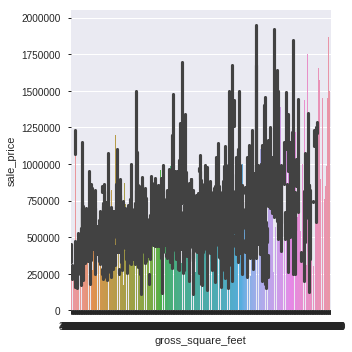

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical plot - bar graph
sns.catplot(x='gross_square_feet', y='sale_price', data=train, kind = 'bar')

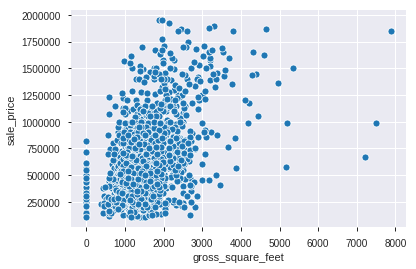

In [24]:
# Scatterplot
sns.scatterplot(x= 'gross_square_feet', y='sale_price', data=train)

In [0]:
# Attempted this for loop, but I am getting an error.

for col in sorted(train.columns):
    if train[col].nunique() < 50:
        sns.catplot(x=col, y='sale_price', data = train, kind = 'bar')
        plt.show();

##  [X] Do one-hot encoding of categorical features.

In [34]:
!pip install category_encoders

In [33]:
# Find non- numeric features

train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
building_class_category,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
apartment_number,1,1,RP.,1,NaN,NaN
tax_class_at_present,2507,2,1,2476,NaN,NaN
building_class_at_time_of_sale,2507,11,A1,919,NaN,NaN
building_class_at_present,2507,13,A1,919,NaN,NaN
sale_date,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
neighborhood,2507,176,FLUSHING-NORTH,77,NaN,NaN
land_square_feet,2507,887,"4,000",234,NaN,NaN
address,2507,2497,57 CHESTNUT STREET,2,NaN,NaN


In [37]:
import category_encoders as ce 

encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['tax_class_at_present'])
encoded.head()

,tax_class_at_present_1,tax_class_at_present_1D
44,1,0
61,1,0
78,1,0
108,1,0
111,1,0


In [39]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['neighborhood'])
encoded.head()

,neighborhood_OCEAN PARKWAY-NORTH,neighborhood_QUEENS VILLAGE,neighborhood_PELHAM PARKWAY SOUTH,neighborhood_FLATBUSH-CENTRAL,neighborhood_FLATBUSH-EAST,neighborhood_MADISON,neighborhood_MIDWOOD,neighborhood_BAYSIDE,neighborhood_ELMHURST,neighborhood_FLUSHING-NORTH,neighborhood_HOLLIS,neighborhood_HOWARD BEACH,neighborhood_JACKSON HEIGHTS,neighborhood_KEW GARDENS,neighborhood_LAURELTON,neighborhood_SO. JAMAICA-BAISLEY PARK,neighborhood_SOUTH JAMAICA,neighborhood_SPRINGFIELD GARDENS,neighborhood_ELTINGVILLE,neighborhood_GREAT KILLS,neighborhood_MANOR HEIGHTS,neighborhood_WESTERLEIGH,neighborhood_CANARSIE,neighborhood_DYKER HEIGHTS,neighborhood_EAST NEW YORK,neighborhood_GERRITSEN BEACH,neighborhood_OLD MILL BASIN,neighborhood_CAMBRIA HEIGHTS,neighborhood_CORONA,neighborhood_DOUGLASTON,neighborhood_FAR ROCKAWAY,neighborhood_FLUSHING-SOUTH,neighborhood_FRESH MEADOWS,neighborhood_HOLLISWOOD,neighborhood_JAMAICA,neighborhood_JAMAICA ESTATES,neighborhood_LITTLE NECK,neighborhood_RIDGEWOOD,neighborhood_SOUTH OZONE PARK,neighborhood_CASTLETON CORNERS,...,neighborhood_MORRIS PARK/VAN NEST,neighborhood_BOERUM HILL,neighborhood_CONEY ISLAND,neighborhood_MILL BASIN,neighborhood_KINGSBRIDGE HTS/UNIV HTS,neighborhood_SUNSET PARK,neighborhood_GRYMES HILL,neighborhood_NEW DORP,neighborhood_STAPLETON,neighborhood_PARK SLOPE SOUTH,neighborhood_LIVINGSTON,neighborhood_TOMPKINSVILLE,neighborhood_CITY ISLAND,neighborhood_GLEN OAKS,neighborhood_NEPONSIT,neighborhood_DONGAN HILLS,neighborhood_STAPLETON-CLIFTON,neighborhood_ARVERNE,neighborhood_FLATBUSH-LEFFERTS GARDEN,neighborhood_BELLE HARBOR,neighborhood_EMERSON HILL,neighborhood_BATH BEACH,neighborhood_HILLCREST,neighborhood_OCEAN HILL,neighborhood_MORRISANIA/LONGWOOD,neighborhood_CLINTON HILL,neighborhood_ARROCHAR,neighborhood_TRAVIS,neighborhood_BUSHWICK,neighborhood_HOLLIS HILLS,neighborhood_BROAD CHANNEL,neighborhood_INWOOD,neighborhood_CROTONA PARK,neighborhood_BATHGATE,neighborhood_ROSSVILLE-RICHMOND VALLEY,neighborhood_BELMONT,neighborhood_MOUNT HOPE/MOUNT EDEN,neighborhood_PARKCHESTER,neighborhood_DONGAN HILLS-OLD TOWN,neighborhood_FIELDSTON
44,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['land_square_feet'])
encoded.head()

,"land_square_feet_6,800","land_square_feet_4,000","land_square_feet_3,500","land_square_feet_1,710","land_square_feet_2,000","land_square_feet_3,000","land_square_feet_1,800","land_square_feet_5,000","land_square_feet_2,400","land_square_feet_7,000","land_square_feet_3,700","land_square_feet_2,500","land_square_feet_2,435",land_square_feet_760,"land_square_feet_3,920","land_square_feet_2,626","land_square_feet_1,383","land_square_feet_2,200","land_square_feet_3,570","land_square_feet_8,600","land_square_feet_7,107","land_square_feet_4,629","land_square_feet_3,800","land_square_feet_4,242","land_square_feet_5,500","land_square_feet_9,383","land_square_feet_3,984","land_square_feet_4,900","land_square_feet_1,635","land_square_feet_2,160","land_square_feet_3,068","land_square_feet_4,482","land_square_feet_3,655","land_square_feet_1,403","land_square_feet_4,410","land_square_feet_2,325","land_square_feet_2,527","land_square_feet_2,058","land_square_feet_6,935","land_square_feet_3,228",...,"land_square_feet_9,975","land_square_feet_8,640","land_square_feet_2,595","land_square_feet_1,251","land_square_feet_2,746","land_square_feet_2,024",land_square_feet_864,"land_square_feet_4,378","land_square_feet_7,436","land_square_feet_5,250","land_square_feet_2,052","land_square_feet_1,470","land_square_feet_3,071","land_square_feet_2,270","land_square_feet_5,425","land_square_feet_1,767","land_square_feet_1,293","land_square_feet_2,708","land_square_feet_2,233","land_square_feet_2,260","land_square_feet_5,005","land_square_feet_1,235","land_square_feet_4,298","land_square_feet_1,060",land_square_feet_946,"land_square_feet_1,698","land_square_feet_3,990","land_square_feet_3,012","land_square_feet_2,231","land_square_feet_4,485","land_square_feet_1,918","land_square_feet_2,020","land_square_feet_1,380","land_square_feet_3,338","land_square_feet_3,692","land_square_feet_2,755","land_square_feet_3,230","land_square_feet_2,121","land_square_feet_4,361","land_square_feet_3,910"
44,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## [X] Do feature selection with `SelectKBest`.

In [41]:
# How many features are there?

target = 'sale_price'
features = train.columns.drop(target)
len(features)

20

In [42]:
# How many ways to choose 1 feature?
from itertools import combinations
len(list(combinations(features, 1)))

20

In [43]:
# How many ways to choose 2 features
len(list(combinations(features, 2)))

190

In [50]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'sale_price'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2507, 10), (2507,), (644, 10), (644,))

In [52]:
#Select the 10 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest

#This is similar to the way we did linear regression last time
#model = LinearRegression()
#model.fit(...)

selector = SelectKBest(score_func=f_regression, k = 10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2507, 10), (644, 10))

In [53]:
# Which features were selected?

#selector.get_support()

all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)



Features selected:
borough
block
lot
zip_code
residential_units
commercial_units
total_units
gross_square_feet
year_built
tax_class_at_time_of_sale


## [X] Fit a linear regression model with multiple features.
## [X] Get mean absolute error for the test set.

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $167,806
